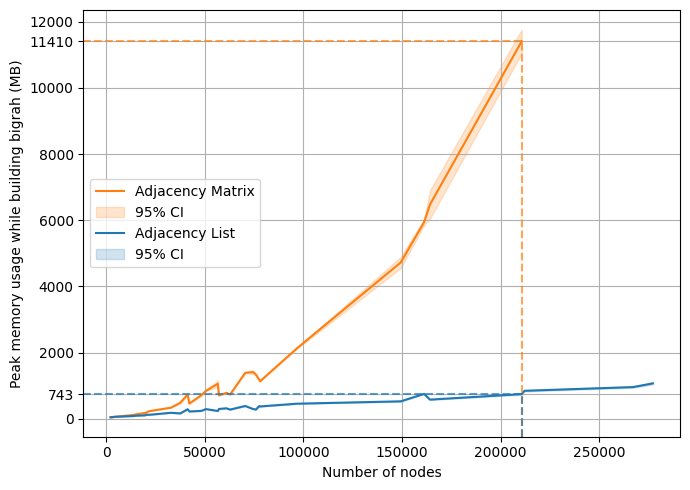

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem, t
from matplotlib.ticker import FormatStrFormatter

# Load both CSV files
df1 = pd.read_csv("experiment_results_build.csv")
df2 = pd.read_csv("experiment_results_build_BitIntSet.csv")

def prep_df(df):
    df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
    df["Maximum resident set size (kbytes)"] = pd.to_numeric(df["Maximum resident set size (kbytes)"], errors="coerce")
    df = df.sort_values("Number of nodes")
    means = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].mean() / 1024  # MB
    counts = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].count()
    sems = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].apply(sem)
    conf95 = sems * t.ppf(0.975, counts-1) / 1024  # MB
    return means, conf95, df

means1, conf95_1, df1 = prep_df(df1)
means2, conf95_2, df2 = prep_df(df2)

plt.figure(figsize=(7, 5))

plt.plot(means2.index, means2.values, label="Adjacency Matrix", color="tab:orange")
plt.fill_between(means2.index, means2.values - conf95_2, means2.values + conf95_2, color="tab:orange", alpha=0.2, label="95% CI")
# plt.scatter(df2["Number of nodes"], df2["Maximum resident set size (kbytes)"] / 1024, color="tab:orange", alpha=0.4, s=20)

plt.plot(means1.index, means1.values, label="Adjacency List", color="tab:blue")
plt.fill_between(means1.index, means1.values - conf95_1, means1.values + conf95_1, color="tab:blue", alpha=0.2,label="95% CI")
# plt.scatter(df1["Number of nodes"], df1["Maximum resident set size (kbytes)"] / 1024, color="tab:blue", alpha=0.4, s=20)

xlim = plt.xlim()
ylim = plt.ylim()
y2=means2[210768]
y1=means1[210768]
plt.hlines(y=y2, xmin=xlim[0], xmax=210768,linestyle="dashed", color="tab:orange", alpha=0.7)
plt.vlines(x=210768, ymin=ylim[0], ymax=y2,linestyle="dashed", color="tab:orange", alpha=0.7)
# plt.plot(210768,y2,'o', color="tab:orange")
# plt.text(210768, y2, "Cambridgeshire", fontsize=8, ha='left', va='top')
plt.hlines(y=y1, xmin=xlim[0], xmax=210768,linestyle="dashed", color="tab:blue", alpha=0.7)
plt.vlines(x=210768, ymin=ylim[0], ymax=y1,linestyle="dashed", color="tab:blue", alpha=0.7)
# plt.text(210768, y1, "Cambridgeshire", fontsize=8, ha='left', va='top')
# plt.plot(210768,y1,'o', color="tab:blue")
plt.xlim(xlim)
plt.yticks(list(plt.yticks()[0]) + [means2[210768],means1[210768]])
plt.ylim(ylim)

plt.xlabel("Number of nodes")
plt.ylabel("Peak memory usage while building bigrah (MB)")
# plt.title("Peak Memory usage vs Number of nodes\n(Adjacency Matrix vs Adjacency List)")
plt.grid(True)
plt.legend(loc='center left')
plt.tight_layout()
plt.show()

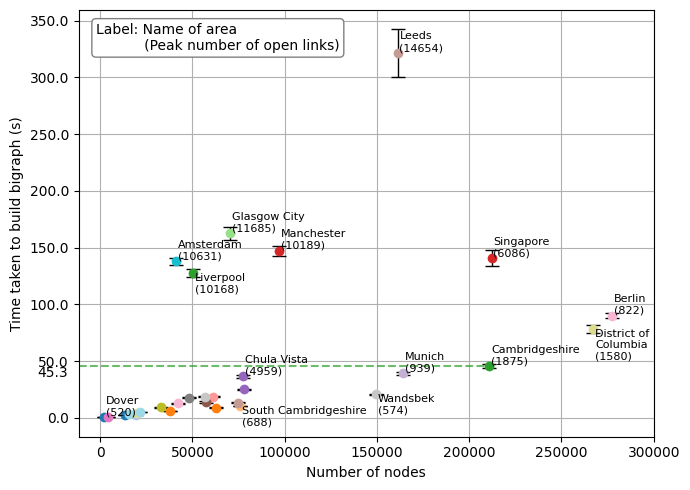

In [50]:
df = pd.read_csv("experiment_results_build.csv")
# Drop rows with missing values in relevant columns
df = df.dropna(subset=["Bigraph built in", "Number of nodes", "name", "Number of open links"])

# Group by 'name' and 'Number of nodes'
grouped = df.groupby(["name", "Number of nodes"])

means = grouped["Bigraph built in"].mean()
counts = grouped["Bigraph built in"].count()
sems = grouped["Bigraph built in"].apply(sem)
conf95 = sems * t.ppf(0.975, counts-1)

# Prepare plot
plt.figure(figsize=(7, 5))

names = df["name"].unique()
colors = plt.get_cmap("tab20", len(names))
camb_color = colors(0)

for idx, name in enumerate(names):
    if name == "Cambridgeshire":
        camb_color = colors(idx)
    name_means = means.loc[name]
    name_conf = conf95.loc[name]
    name_nodes = name_means.index
    plt.errorbar(
        name_nodes, name_means.values, yerr=name_conf.values,
        fmt='o', 
        label=name, color=colors(idx),
        capsize=5, ecolor="black", elinewidth=1
    )
    # Add label beside each mean point
    for x, y in zip(name_nodes, name_means.values):
        # Get max of Number of open links for this (name, node)
        open_links_str = df[(df["name"] == name) & (df["Number of nodes"] == x)]["Number of open links"].iloc[0]
        try:
            open_links = [int(v) for v in str(open_links_str).split(";") if v.strip() != ""]
            max_open_links = max(open_links) if open_links else 0
        except Exception:
            max_open_links = 0
        if name=="District of Columbia":
            plt.text(x+1000, y, f"District of\nColumbia\n({max_open_links})", fontsize=8, ha='left', va='top')
        elif name=="South Cambridgeshire" or name=="Liverpool" or name=="Wandsbek":
            plt.text(x+1000, y, f"{name}\n({max_open_links})", fontsize=8, ha='left', va='top')
        elif x>100000 or y>100 or name=="Dover" or name=="Chula Vista":
            plt.text(x+1000, y, f"{name}\n({max_open_links})", fontsize=8, ha='left', va='bottom')

plt.xlabel("Number of nodes")
plt.ylabel("Time taken to build bigraph (s)")
# plt.title("Time to Build Bigraph vs Number of nodes")
# plt.legend()

plt.text(
    0.03, 0.97,  # x, y position in axes fraction (0-1)
    "Label: Name of area\n           (Peak number of open links)", 
    transform=plt.gca().transAxes,  # Use axes coordinates
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray')
)

camb_mean = means.loc["Cambridgeshire"].values[0]
xlim = (plt.xlim()[0],300000)
ylim = plt.ylim()
plt.hlines(y=camb_mean, xmin=xlim[0], xmax=210768,linestyle="dashed", color=camb_color, alpha=0.7)
plt.xlim(xlim)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
plt.yticks(list(plt.yticks()[0]) )
plt.text(xlim[0]-6000, camb_mean, "{:.1f}".format(camb_mean), ha='right', va='top')
plt.ylim(ylim)

plt.grid(True)
plt.tight_layout()
plt.show()

# Load

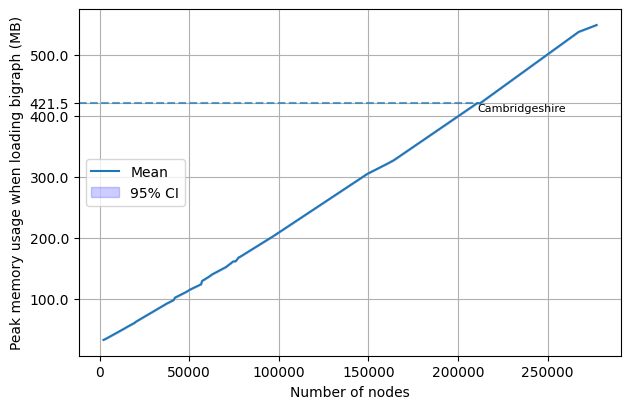

In [51]:
df = pd.read_csv("experiment_results_load.csv")

# Convert columns to numeric
df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
df["Maximum resident set size (kbytes)"] = pd.to_numeric(df["Maximum resident set size (kbytes)"], errors="coerce")

# Sort by Number of nodes
df = df.sort_values("Number of nodes")

# Group by Number of nodes and calculate mean and 95% CI
means = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].mean() / 1024  # MB
counts = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].count()
sems = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].apply(sem)
conf95 = sems * t.ppf(0.975, counts-1) / 1024  # MB

x = means.index
y = means.values

plt.figure(figsize=(7, 4.5))
plt.plot(x, y, label="Mean")
plt.fill_between(x, y - conf95, y + conf95, color="b", alpha=0.2, label="95% CI")
# plt.scatter(df["Number of nodes"], df["Maximum resident set size (kbytes)"] / 1024, color="gray", alpha=0.5, label="Data points")

xlim = plt.xlim()
ylim = plt.ylim()
plt.hlines(y=means[210768], xmin=xlim[0], xmax=210768,linestyle="dashed", alpha=0.7)
plt.text(210768, means[210768], "Cambridgeshire", fontsize=8, ha='left', va='top')
plt.xlim(xlim)
plt.yticks(list(plt.yticks()[0]) + [means[210768]])
plt.ylim(ylim)

plt.xlabel("Number of nodes")
plt.ylabel("Peak memory usage when loading bigraph (MB)")
# plt.title("Maximum resident set size vs Number of nodes (load)\nMean and 95% Confidence Interval")
plt.grid(True)
plt.legend(loc='center left')
plt.show()

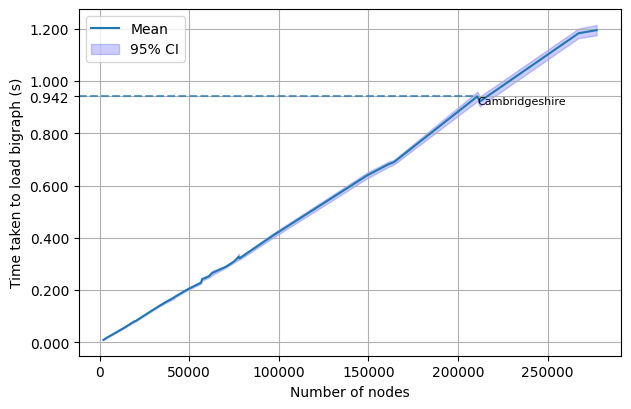

In [52]:
df = pd.read_csv("experiment_results_load.csv")

# Convert columns to numeric
df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
df["Bigraph loaded in"] = pd.to_numeric(df["Bigraph loaded in"], errors="coerce")

# Sort by Number of nodes
df = df.sort_values("Number of nodes")

# Group by Number of nodes and calculate mean and 95% CI
means = df.groupby("Number of nodes")["Bigraph loaded in"].mean()
counts = df.groupby("Number of nodes")["Bigraph loaded in"].count()
sems = df.groupby("Number of nodes")["Bigraph loaded in"].apply(sem)
conf95 = sems * t.ppf(0.975, counts-1)

x = means.index
y = means.values

plt.figure(figsize=(7, 4.5))
plt.plot(x, y, label="Mean")
plt.fill_between(x, y - conf95, y + conf95, color="b", alpha=0.2, label="95% CI")
# plt.scatter(df["Number of nodes"], df["Bigraph loaded in"], color="gray", alpha=0.2, label="Data points")

xlim = plt.xlim()
ylim = plt.ylim()
plt.hlines(y=means[210768], xmin=xlim[0], xmax=210768,linestyle="dashed", alpha=0.7)
plt.text(210768, means[210768], "Cambridgeshire", fontsize=8, ha='left', va='top')
plt.xlim(xlim)
plt.yticks(list(plt.yticks()[0]) + [means[210768]])
plt.ylim(ylim)

plt.xlabel("Number of nodes")
plt.ylabel("Time taken to load bigraph (s)")
# plt.title("Bigraph loaded in vs Number of nodes (load)\nMean and 95% Confidence Interval")
plt.grid(True)
plt.legend()
plt.show()

# One reaction

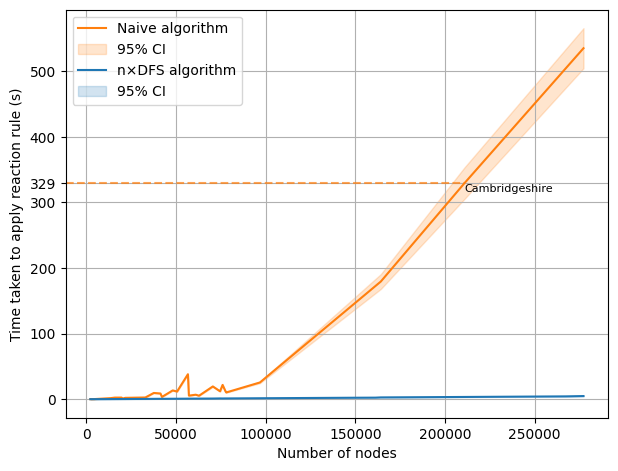

In [53]:
# Load both CSV files
df1 = pd.read_csv("experiment_results_dfs_trans.csv")
df2 = pd.read_csv("experiment_results_naive_trans.csv")

# Convert columns to numeric
for df in [df1, df2]:
    df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
    df["leave_building"] = pd.to_numeric(df["leave_building"], errors="coerce")

def plot_leave_building(df, label, color):
    means = df.groupby("Number of nodes")["leave_building"].mean()
    counts = df.groupby("Number of nodes")["leave_building"].count()
    sems = df.groupby("Number of nodes")["leave_building"].apply(sem)
    conf95 = sems * t.ppf(0.975, counts-1)
    plt.plot(means.index, means.values, label=label, color=color)
    plt.fill_between(means.index, means.values - conf95, means.values + conf95, color=color, alpha=0.2, label="95% CI")
    # plt.scatter(df["Number of nodes"], df["leave_building"], color=color, alpha=0.4, s=20, label="Data points")

plt.figure(figsize=(7,5.3))
plot_leave_building(df2, "Naive algorithm", "tab:orange")
plot_leave_building(df1, "n×DFS algorithm", "tab:blue")

means2 = df2.groupby("Number of nodes")["leave_building"].mean()

xlim = plt.xlim()
ylim = plt.ylim()
plt.hlines(y=means2[210768], xmin=xlim[0], xmax=210768,linestyle="dashed", alpha=0.7, color="tab:orange")
plt.text(210768, means2[210768], "Cambridgeshire", fontsize=8, ha='left', va='top')
plt.xlim(xlim)
plt.yticks(list(plt.yticks()[0]) + [means2[210768]])
plt.ylim(ylim)

plt.xlabel("Number of nodes")
plt.ylabel("Time taken to apply reaction rule (s)")
# plt.title("leave_building vs Number of nodes\n(DFS Trans vs Naive Trans, Mean and 95% CI)")
plt.grid(True)
plt.legend()
plt.show()

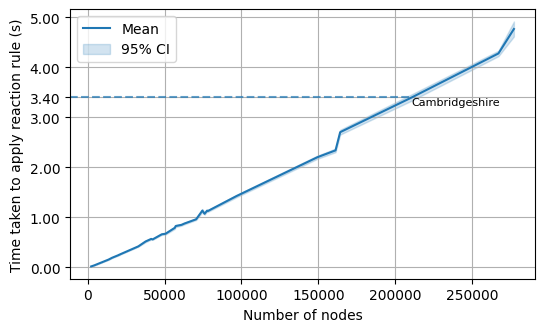

In [54]:
# Load both CSV files
df1 = pd.read_csv("experiment_results_dfs_trans.csv")

# Convert columns to numeric
for df in [df1]:
    df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
    df["leave_building"] = pd.to_numeric(df["leave_building"], errors="coerce")

def plot_leave_building(df, label, color):
    means = df.groupby("Number of nodes")["leave_building"].mean()
    counts = df.groupby("Number of nodes")["leave_building"].count()
    sems = df.groupby("Number of nodes")["leave_building"].apply(sem)
    conf95 = sems * t.ppf(0.975, counts-1)
    plt.plot(means.index, means.values, label=label, color=color)
    plt.fill_between(means.index, means.values - conf95, means.values + conf95, color=color, alpha=0.2, label="95% CI")
    # plt.scatter(df["Number of nodes"], df["leave_building"], color=color, alpha=0.4, s=20, label="Data points")

plt.figure(figsize=(6, 3.5))
plot_leave_building(df1, "Mean", "tab:blue")

means = df.groupby("Number of nodes")["leave_building"].mean()

xlim = plt.xlim()
ylim = plt.ylim()
plt.hlines(y=means[210768], xmin=xlim[0], xmax=210768,linestyle="dashed", alpha=0.7, color="tab:blue")
plt.text(210768, means[210768], "Cambridgeshire", fontsize=8, ha='left', va='top')
plt.xlim(xlim)
plt.yticks(list(plt.yticks()[0]) + [means[210768]])
plt.ylim(ylim)

plt.xlabel("Number of nodes")
plt.ylabel("Time taken to apply reaction rule (s)")
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.title("leave_building vs Number of nodes\n(DFS Trans vs Naive Trans, Mean and 95% CI)")
plt.grid(True)
plt.legend()
plt.show()

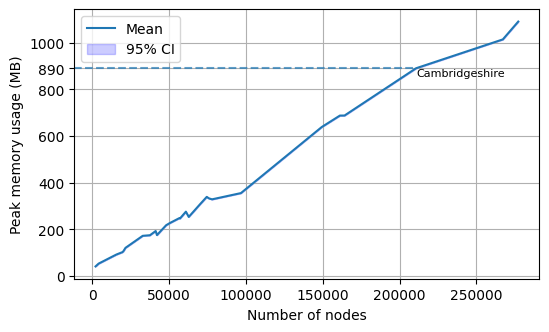

In [55]:
# Load CSV file
df = pd.read_csv("experiment_results_dfs_trans.csv")

# Convert columns to numeric
df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
df["Maximum resident set size (kbytes)"] = pd.to_numeric(df["Maximum resident set size (kbytes)"], errors="coerce")

# Sort by Number of nodes
df = df.sort_values("Number of nodes")

# Group by Number of nodes and calculate mean and 95% CI
means = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].mean() / 1024  # MB
counts = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].count()
sems = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].apply(sem)
conf95 = sems * t.ppf(0.975, counts-1) / 1024  # MB

x = means.index
y = means.values

plt.figure(figsize=(6, 3.5))
plt.plot(x, y, label="Mean")
plt.fill_between(x, y - conf95, y + conf95, color="b", alpha=0.2, label="95% CI")
# plt.scatter(df["Number of nodes"], df["Maximum resident set size (kbytes)"] / 1024, color="gray", alpha=0.5, label="Data points")

xlim = plt.xlim()
ylim = plt.ylim()
plt.hlines(y=means[210768], xmin=xlim[0], xmax=210768,linestyle="dashed", alpha=0.7,)
plt.text(210768, means[210768], "Cambridgeshire", fontsize=8, ha='left', va='top')
plt.xlim(xlim)
plt.yticks(list(plt.yticks()[0]) + [means[210768]])
plt.ylim(ylim)

plt.xlabel("Number of nodes")
plt.ylabel("Peak memory usage (MB)")
# plt.title("Maximum resident set size vs Number of nodes (DFS Trans)\nMean and 95% Confidence Interval")
plt.grid(True)
plt.legend()
plt.show()

# All reactions

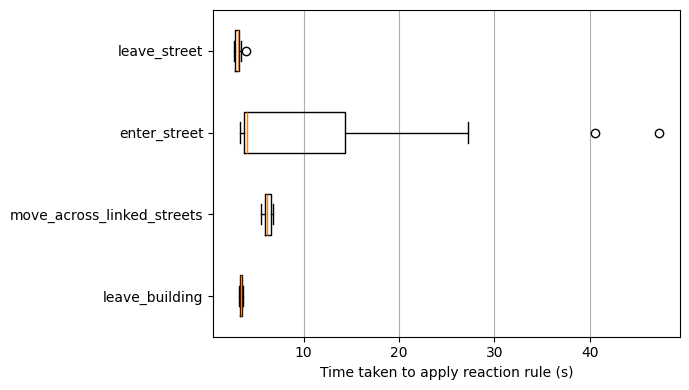

In [56]:
# Load CSV file
df = pd.read_csv("experiment_results_reactions.csv")

# List of columns to plot
columns = [
    "leave_street",
    "enter_street",
    "move_across_linked_streets",
    "leave_building",
    # "enter_building (starting in street)",
    # "enter_building_from_street",
    # "enter_building (starting in boundary)",
    # "enter_building_from_boundary",
]
columns.reverse()

# Convert columns to numeric
for col in columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop columns with all NaN values
data = [df[col].dropna() for col in columns if not df[col].dropna().empty]
labels = [col for col in columns if not df[col].dropna().empty]

plt.figure(figsize=(7, 4))
plt.boxplot(data, tick_labels=labels, vert=False, widths=0.5)
plt.xlabel("Time taken to apply reaction rule (s)")
# plt.title("Horizontal box plots of reaction times")
# plt.yticks(rotation=30, ha="right")
plt.grid(axis="x")
plt.tight_layout()
plt.show()

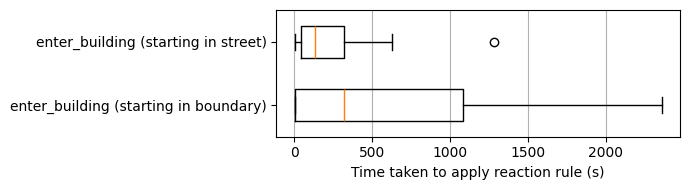

In [57]:
# Load CSV file
df = pd.read_csv("experiment_results_reactions.csv")

# List of columns to plot
columns = [
    # "leave_street",
    # "enter_street",
    # "move_across_linked_streets",
    # "leave_building",
    "enter_building (starting in street)",
    # "enter_building_from_street",
    "enter_building (starting in boundary)",
    # "enter_building_from_boundary",
]
columns.reverse()

# Convert columns to numeric
for col in columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop columns with all NaN values
data = [df[col].dropna() for col in columns if not df[col].dropna().empty]
labels = [col for col in columns if not df[col].dropna().empty]

plt.figure(figsize=(7, 2))
plt.boxplot(data, tick_labels=labels, vert=False, widths=0.5)
plt.xlabel("Time taken to apply reaction rule (s)")
# plt.title("Horizontal box plots of reaction times")
# plt.yticks(rotation=30, ha="right")
plt.grid(axis="x")
plt.tight_layout()
plt.show()

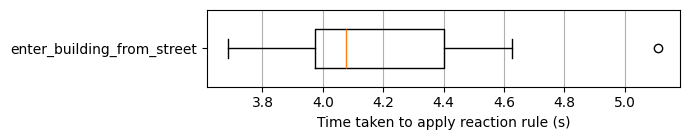

In [58]:
# Load CSV file
df = pd.read_csv("experiment_results_reactions.csv")

# List of columns to plot
columns = [
    # "leave_street",
    # "enter_street",
    # "leave_building",
    "enter_building_from_street",
    # "enter_building_from_boundary",
    # "move_across_linked_streets",
]
columns.reverse()

# Convert columns to numeric
for col in columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop columns with all NaN values
data = [df[col].dropna() for col in columns if not df[col].dropna().empty]
labels = [col for col in columns if not df[col].dropna().empty]

plt.figure(figsize=(7, 1.5))
plt.boxplot(data, tick_labels=labels, vert=False, widths=0.5)
plt.xlabel("Time taken to apply reaction rule (s)")
# plt.title("Horizontal box plots of reaction times")
# plt.yticks(rotation=30, ha="right")
plt.grid(axis="x")
plt.tight_layout()
plt.show()

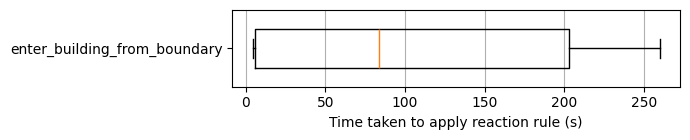

In [59]:
# Load CSV file
df = pd.read_csv("experiment_results_reactions.csv")

# List of columns to plot
columns = [
    # "leave_street",
    # "enter_street",
    # "leave_building",
    # "enter_building_from_street",
    "enter_building_from_boundary",
    # "move_across_linked_streets",
]
columns.reverse()

# Convert columns to numeric
for col in columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop columns with all NaN values
data = [df[col].dropna() for col in columns if not df[col].dropna().empty]
labels = [col for col in columns if not df[col].dropna().empty]

plt.figure(figsize=(7, 1.5))
plt.boxplot(data, tick_labels=labels, vert=False, widths=0.5)
plt.xlabel("Time taken to apply reaction rule (s)")
# plt.title("Horizontal box plots of reaction times")
# plt.yticks(rotation=30, ha="right")
plt.grid(axis="x")
plt.tight_layout()
plt.show()